In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Average,Maximum
from keras.layers.core import Activation, Lambda, Dropout, Flatten 
from keras.layers.merge import concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import load_model
from keras.engine.topology import Layer,InputSpec
from keras.callbacks import TensorBoard,ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.engine.topology import Layer,InputSpec

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt

sess = tf.Session()
K.set_session(sess)
K.set_image_dim_ordering("th")


/home/rjpg/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/rjpg/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
dfin = pd.read_csv('../NNNormalizeDataInVal.csv',header=None)  #inputs 128 lines per sample
dfout = pd.read_csv('../NNNormalizeDataOutClasssesVal.csv',header=None)  #output classes 

#print(dfin.shape)
#print(dfout.shape)

################################################### CNN INPUTS ####################################

#dfin_modelCNN = dfin.drop(dfin.columns[[2,3,4]], axis=1)  #remove some vars
dfin_modelCNN=dfin ## use all vars 

CNN_STEPS, CNN_VARS = 128, dfin_modelCNN.shape[1] 

total_inputs_CNN , total_output = dfin_modelCNN.as_matrix().astype(np.float32) , dfout.as_matrix().astype(np.int32)

#total_inputs_CNN = np.reshape(total_inputs_CNN, (-1,CNN_STEPS, CNN_VARS))
total_inputs_CNN = np.reshape(total_inputs_CNN, (-1,8,16,9))

#train_inputs_CNN, test_inputs_CNN, train_output, test_output = non_shuffling_train_test_split(total_inputs_CNN, total_output, test_size=1.0)

test_inputs_CNN, test_output  = total_inputs_CNN, total_output
#print(train_inputs_CNN)
#print(train_output)

X_test_CNN = test_inputs_CNN[:,:, np.newaxis, :, :]


INPUT_SHAPE_CNN = (1, CNN_STEPS, CNN_VARS)

################################################### LSTM INPUTS ####################################
dfin_modelLSTM = dfin 

LSTM_STEPS, LSTM_VARS = 128, dfin_modelLSTM.shape[1]

total_inputs_LSTM , total_output = dfin_modelLSTM.as_matrix().astype(np.float32) , dfout.as_matrix().astype(np.int32)

total_inputs_LSTM = np.reshape(total_inputs_LSTM, (-1,LSTM_STEPS, LSTM_VARS))

#train_inputs_LSTM, test_inputs_LSTM, train_output, test_output = non_shuffling_train_test_split(total_inputs_LSTM, total_output, test_size=0.2)

test_inputs_LSTM, test_output  = total_inputs_LSTM, total_output

#print(train_inputs_LSTM)
#print(train_output)

X_test_LSTM = test_inputs_LSTM

INPUT_SHAPE_LSTM = (1, LSTM_STEPS, LSTM_VARS)

################################################### OUTPUTS ########################################
NB_CLASSES = 5  # number of outputs = number of classes

y_test = np_utils.to_categorical(test_output, NB_CLASSES)


print("load e formatação completa")

load e formatação completa


/home/rjpg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/rjpg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [5]:
class CylindricalPadLSTMCNN2D(Layer):

    def __init__(self, m=0,n=1, **kwargs):
        super(CylindricalPadLSTMCNN2D, self).__init__(**kwargs)
        self.n = n
        self.m = m
        assert n > 0, 'n must be positive'
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(CylindricalPadLSTMCNN2D, self).build(input_shape)  
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    input_shape[2],
                    input_shape[3] + 2*self.m,
                    input_shape[4] + 2*self.n)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    input_shape[2],
                    input_shape[3] + 2*self.m,
                    input_shape[4] + 2*self.n)
    
    def call(self,testElement, mask=None):
        firstColumns=testElement[:,:,:,:,0:self.n]
        lastColumns=testElement[:,:,:,:,testElement.shape[4]-self.n:testElement.shape[4]]
        result=tf.concat([testElement,firstColumns], axis=4)
        result=tf.concat([lastColumns,result], axis=4)
        if self.m != 0 :
            #x = tf.placeholder(result.dtype, shape=[result.shape[0],result.shape[1],self.m,result.shape[3]])
            #y = tf.zeros_like(x,dtype=result.dtype)
            
            firstRows=result[:,:,:,0:self.m,:]
            
            y = tf.fill(tf.shape(firstRows), 0.)
            
            #y=tf.fill([result.shape[0],result.shape[1],self.m,result.shape[3]],0.)
            
            #y = tf.constant(0., shape=[result.shape[0],result.shape[1],self.m,result.shape[3]],dtype=result.dtype)
            result=tf.concat([y,result], axis=3)
            result=tf.concat([result,y], axis=3)
        
        return result

    def get_config(self):
        config = {'n': self.n,
        'm': self.m}
        base_config = super(CylindricalPadLSTMCNN2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

print("CylindricalPadLSTMCNN2D class layer defined")

CylindricalPadLSTMCNN2D class layer defined


In [6]:
modelLSTM = load_model('lstm_new_data.h5')

modelCNN = load_model('lstmCÑN_new_data.h5')#, custom_objects={'CylindricalPad':CylindricalPad})

modelCNNLSTMROLL = load_model('lstmCÑNROLL_new_data.h5', custom_objects={'CylindricalPadLSTMCNN2D':CylindricalPadLSTMCNN2D})


print('Confusion Matrix-CNN')
cm_CNN=confusion_matrix(np.argmax(y_test,axis=1), np.argmax(modelCNN.predict(X_test_CNN),axis=1))
print(cm_CNN)
scores = modelCNN.evaluate(X_test_CNN,y_test, verbose=0)
print("Dados Valiação %s: %.2f%%" % (modelCNN.metrics_names[1], scores[1]*100))

print('Confusion Matrix-LSTM')
cm_LSTM=confusion_matrix(np.argmax(y_test,axis=1), np.argmax(modelLSTM.predict(X_test_LSTM),axis=1))
print(cm_LSTM)
scores = modelLSTM.evaluate(X_test_LSTM,y_test, verbose=0)
print("Dados Validação %s: %.2f%%" % (modelLSTM.metrics_names[1], scores[1]*100))

print('Confusion Matrix-CNNLSTMROLL')
cm_CNNLSTMROLL=confusion_matrix(np.argmax(y_test,axis=1), np.argmax(modelCNNLSTMROLL.predict(X_test_CNN),axis=1))
print(cm_CNNLSTMROLL)
scores = modelCNNLSTMROLL.evaluate(X_test_CNN,y_test, verbose=0)
print("Dados Validação %s: %.2f%%" % (modelCNNLSTMROLL.metrics_names[1], scores[1]*100))






Confusion Matrix-CNN
[[12  4  3  4  4]
 [ 7  7  8  6  7]
 [ 7 10  6  4  1]
 [ 8  3  2  3  7]
 [ 6  2  5  4  8]]
Dados Valiação acc: 26.09%
Confusion Matrix-LSTM
[[15  5  2  4  1]
 [ 9 11  2  4  9]
 [16  2  1  6  3]
 [11  1  0  2  9]
 [ 3  4  0  4 14]]
Dados Validação acc: 31.16%
Confusion Matrix-CNNLSTMROLL
[[ 3  8  1 10  5]
 [ 4 12  3 11  5]
 [ 3 12  4  6  3]
 [ 4  6  0  6  7]
 [ 2  2  1 12  8]]
Dados Validação acc: 23.91%


In [7]:
print(" ----- LSTM -----")
print("Posições ganhadoras",cm_LSTM[0,0]+cm_LSTM[0,1]+cm_LSTM[1,0]+cm_LSTM[1,1]+cm_LSTM[3,3]+cm_LSTM[3,4]+cm_LSTM[4,3]+cm_LSTM[4,4])
print("Posições perdedoras",cm_LSTM[3,0]+cm_LSTM[3,1]+cm_LSTM[4,0]+cm_LSTM[4,1]+cm_LSTM[0,3]+cm_LSTM[0,4]+cm_LSTM[1,3]+cm_LSTM[1,4])

profit_LSTM=(cm_LSTM[0,0]+cm_LSTM[0,1]+cm_LSTM[1,0]+cm_LSTM[1,1]+cm_LSTM[3,3]+cm_LSTM[3,4]+cm_LSTM[4,3]+cm_LSTM[4,4])-(cm_LSTM[3,0]+cm_LSTM[3,1]+cm_LSTM[4,0]+cm_LSTM[4,1]+cm_LSTM[0,3]+cm_LSTM[0,4]+cm_LSTM[1,3]+cm_LSTM[1,4])

print ("total:", profit_LSTM)

print(" ----- CNN -----")
print("Posições ganhadoras",cm_CNN[0,0]+cm_CNN[0,1]+cm_CNN[1,0]+cm_CNN[1,1]+cm_CNN[3,3]+cm_CNN[3,4]+cm_CNN[4,3]+cm_CNN[4,4])
print("Posições perdedoras",cm_CNN[3,0]+cm_CNN[3,1]+cm_CNN[4,0]+cm_CNN[4,1]+cm_CNN[0,3]+cm_CNN[0,4]+cm_CNN[1,3]+cm_CNN[1,4])

profit_CNN=(cm_CNN[0,0]+cm_CNN[0,1]+cm_CNN[1,0]+cm_CNN[1,1]+cm_CNN[3,3]+cm_CNN[3,4]+cm_CNN[4,3]+cm_CNN[4,4])-(cm_CNN[3,0]+cm_CNN[3,1]+cm_CNN[4,0]+cm_CNN[4,1]+cm_CNN[0,3]+cm_CNN[0,4]+cm_CNN[1,3]+cm_CNN[1,4])

print ("total:",profit_CNN)

print(" ----- CNNLSTMROLL -----")
print("Posições ganhadoras",cm_CNNLSTMROLL[0,0]+cm_CNNLSTMROLL[0,1]+cm_CNNLSTMROLL[1,0]+cm_CNNLSTMROLL[1,1]+cm_CNNLSTMROLL[3,3]+cm_CNNLSTMROLL[3,4]+cm_CNNLSTMROLL[4,3]+cm_CNNLSTMROLL[4,4])
print("Posições perdedoras",cm_CNNLSTMROLL[3,0]+cm_CNNLSTMROLL[3,1]+cm_CNNLSTMROLL[4,0]+cm_CNNLSTMROLL[4,1]+cm_CNNLSTMROLL[0,3]+cm_CNNLSTMROLL[0,4]+cm_CNNLSTMROLL[1,3]+cm_CNNLSTMROLL[1,4])

profit_LSTMCNN2D=(cm_CNNLSTMROLL[0,0]+cm_CNNLSTMROLL[0,1]+cm_CNNLSTMROLL[1,0]+cm_CNNLSTMROLL[1,1]+cm_CNNLSTMROLL[3,3]+cm_CNNLSTMROLL[3,4]+cm_CNNLSTMROLL[4,3]+cm_CNNLSTMROLL[4,4])-(cm_CNNLSTMROLL[3,0]+cm_CNNLSTMROLL[3,1]+cm_CNNLSTMROLL[4,0]+cm_CNNLSTMROLL[4,1]+cm_CNNLSTMROLL[0,3]+cm_CNNLSTMROLL[0,4]+cm_CNNLSTMROLL[1,3]+cm_CNNLSTMROLL[1,4])

print ("total:",profit_LSTMCNN2D)

 ----- LSTM -----
Posições ganhadoras 69
Posições perdedoras 37
total: 32
 ----- CNN -----
Posições ganhadoras 52
Posições perdedoras 40
total: 12
 ----- CNNLSTMROLL -----
Posições ganhadoras 60
Posições perdedoras 45
total: 15


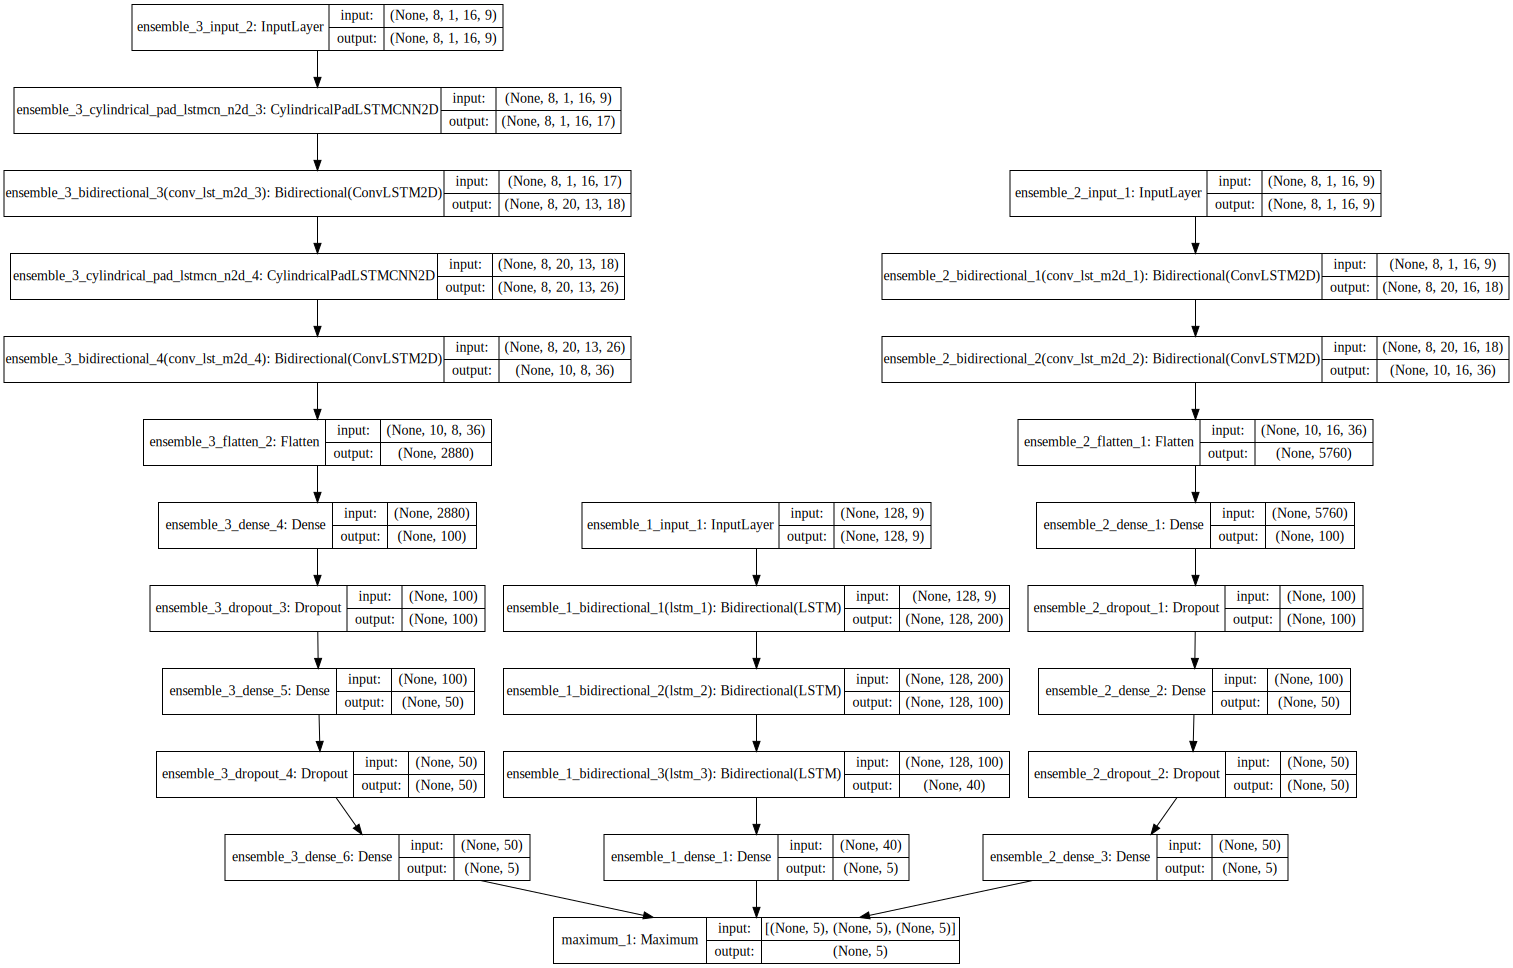

In [8]:
members=[modelLSTM,modelCNN,modelCNNLSTMROLL]


def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	output = Maximum()(ensemble_outputs)

    
    #merge = concatenate(ensemble_outputs)
	#hidden = Dense(100, activation='relu')(merge)
	#output = Dense(5, activation='softmax')(hidden)
    
    
	model = Model(inputs=ensemble_visible, outputs=output)
    
	# plot graph of ensemble
	#plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

stacked_model = define_stacked_model(members)

from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(stacked_model,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

NB_EPOCH = 200
BATCH_SIZE = 64
VERBOSE = 1
OPTIMIZER = Adam()




In [9]:
print('Confusion Matrix-Avegare')
cm_STACK=confusion_matrix(np.argmax(y_test,axis=1), np.argmax(stacked_model.predict([X_test_LSTM,X_test_CNN,X_test_CNN]),axis=1))
print(cm_STACK)



Confusion Matrix-Avegare
[[13  4  0  7  3]
 [ 9  7  4  3 12]
 [10  9  2  5  2]
 [10  2  0  3  8]
 [ 5  2  1  5 12]]


In [10]:
scores = stacked_model.evaluate([X_test_LSTM,X_test_CNN,X_test_CNN],y_test, verbose=0)
print("Ensemble em dados de teste %s: %.2f%%" % (stacked_model.metrics_names[1], scores[1]*100))

Ensemble em dados de teste acc: 26.81%


In [11]:
print("Posições ganhadoras",cm_STACK[0,0]+cm_STACK[0,1]+cm_STACK[1,0]+cm_STACK[1,1]+cm_STACK[3,3]+cm_STACK[3,4]+cm_STACK[4,3]+cm_STACK[4,4])
print("Posições perdedoras",cm_STACK[3,0]+cm_STACK[3,1]+cm_STACK[4,0]+cm_STACK[4,1]+cm_STACK[0,3]+cm_STACK[0,4]+cm_STACK[1,3]+cm_STACK[1,4])
profit_STACK=(cm_STACK[0,0]+cm_STACK[0,1]+cm_STACK[1,0]+cm_STACK[1,1]+cm_STACK[3,3]+cm_STACK[3,4]+cm_STACK[4,3]+cm_STACK[4,4])-(cm_STACK[3,0]+cm_STACK[3,1]+cm_STACK[4,0]+cm_STACK[4,1]+cm_STACK[0,3]+cm_STACK[0,4]+cm_STACK[1,3]+cm_STACK[1,4])

print("################################################")
print ("Posiçõies ganhadoras com ensemble",profit_STACK)
print("################################################")

Posições ganhadoras 61
Posições perdedoras 44
################################################
Posiçõies ganhadoras com ensemble 17
################################################


In [ ]:
# se o essembling fosse com treino
sess.run(tf.global_variables_initializer())


tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=50, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)
best_checkpoint = ModelCheckpoint('ensemble_new_data.h5', monitor='val_acc', save_best_only=True, verbose=1)

history = stacked_model.fit([X_train_LSTM,X_train_CNN], y_train, 
		batch_size=BATCH_SIZE, epochs=400, 
		verbose=2, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
        validation_data=([X_test_LSTM,X_test_CNN],y_test),
		#validation_split=VALIDATION_SPLIT,
        callbacks=[tbCallBack,esCallBack,best_checkpoint])#,reduce_lr,esCallBack])